In [753]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings

from sklearn.model_selection import train_test_split, cross_val_score, KFold, GridSearchCV,           RepeatedKFold
from sklearn.preprocessing import StandardScaler, RobustScaler,                                       MinMaxScaler
from sklearn.manifold import TSNE
from sklearn.ensemble import RandomForestRegressor,                                                   GradientBoostingRegressor
from sklearn.metrics import mean_squared_error as mse, r2_score as r2
from sklearn.linear_model import LinearRegression, ElasticNet, ElasticNetCV, Lasso, LassoCV
from sklearn.decomposition import PCA
from sklearn.svm import SVR
from datetime import datetime
import xgboost as xgb

import seaborn as sns

%matplotlib inline
#%config InlineBackend.figure_format = 'svg'

warnings.filterwarnings('ignore')

#### Datasets

In [754]:
import os
for dirname, _, filenames in list(os.walk('./input/'))[1:2]:
    TRAIN_DATASET_PATH = os.path.join(dirname, filenames[3]).replace("\\","/")
    TEST_DATASET_PATH = os.path.join(dirname, filenames[2]).replace("\\","/")
    SUBMIT = os.path.join(dirname, filenames[1]).replace("\\","/")
        
TRAIN_DATASET_PATH, TEST_DATASET_PATH, SUBMIT 

('./input/real_estate_price_prediction_moscow/test.csv',
 './input/real_estate_price_prediction_moscow/sample_submission.csv',
 './input/real_estate_price_prediction_moscow/rf_submit1_2.csv')

In [755]:
    TRAIN_DATASET_PATH = './input/real_estate_price_prediction_moscow/train.csv'
    TEST_DATASET_PATH = './input/real_estate_price_prediction_moscow/test.csv'
    SUBMIT = './input/real_estate_price_prediction_moscow/submit.csv'

#### Auxiliary functions

In [756]:
def evaluate_preds(train_true_values, train_pred_values, test_true_values, test_pred_values):
    print("Train R2:\t" + str(round(r2(train_true_values, train_pred_values), 3)))
    print("Test R2:\t" + str(round(r2(test_true_values, test_pred_values), 3)))
    
    plt.figure(figsize=(18,10))
    
    plt.subplot(121)
    sns.scatterplot(x=train_pred_values, y=train_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Train sample prediction')
    
    plt.subplot(122)
    sns.scatterplot(x=test_pred_values, y=test_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Test sample prediction')

    plt.show()

In [757]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

#### Loading Train and Test

In [758]:
train_df = pd.read_csv(TRAIN_DATASET_PATH, sep=',')
test_df = pd.read_csv(TEST_DATASET_PATH, sep=',')
train_df = reduce_mem_usage(train_df)

Memory usage of dataframe is 1.53 MB
Memory usage after optimization is: 0.49 MB
Decreased by 68.1%


In [759]:
print(f'Strings in train: {train_df.shape[0]}')
print(f'Strings in test: {test_df.shape[0]}')

Strings in train: 10000
Strings in test: 5000


In [760]:
# check the number of columns (train have col=Price --> target)
train_df.shape[1] - test_df.shape[1] == 1

True

#### Target distribution

In [761]:
train_df.head(3)
train_df.describe()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
count,10000.00000,10000.000000,10000.000000,10000.000000,7887.000000,10000.000000,10000.000000,10000.0000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,5202.000000,10000.000000,10000.000000,10000.000000
mean,8383.40770,50.400800,1.890500,56.315720,37.199665,6.273300,8.526700,12.6094,3.990166e+03,0.118858,24.687000,5352.157400,8.039200,1142.904419,1.319500,4.231300,214138.937500
std,4859.01902,43.587592,0.839522,21.058716,86.241219,28.560839,5.241148,6.7762,2.005003e+05,0.119025,17.532614,4006.799803,23.831875,1021.519470,1.493601,4.806341,92872.273438
min,0.00000,0.000000,0.000000,1.136859,0.370619,0.000000,1.000000,0.0000,1.910000e+03,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,59174.777344
25%,4169.50000,20.000000,1.000000,41.774879,22.769833,1.000000,4.000000,9.0000,1.974000e+03,0.017647,6.000000,1564.000000,0.000000,350.000000,0.000000,1.000000,153872.628906
50%,8394.50000,36.000000,2.000000,52.513309,32.781261,6.000000,7.000000,13.0000,1.977000e+03,0.075424,25.000000,5285.000000,2.000000,900.000000,1.000000,3.000000,192269.648438
75%,12592.50000,75.000000,2.000000,65.900627,45.128803,9.000000,12.000000,17.0000,2.001000e+03,0.195781,36.000000,7227.000000,5.000000,1548.000000,2.000000,6.000000,249135.460938
max,16798.00000,209.000000,19.000000,641.065186,7480.592285,2014.000000,42.000000,117.0000,2.005201e+07,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,633233.437500


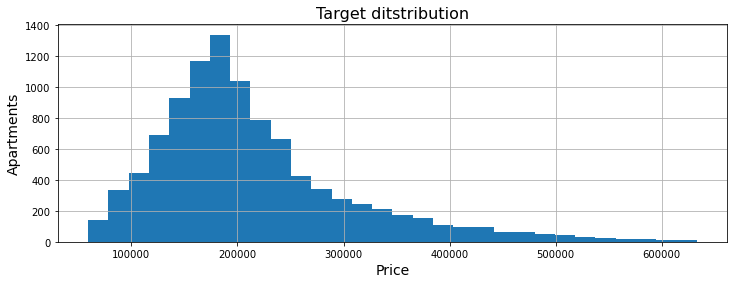

In [762]:
plt.figure(figsize=(12, 4))
train_df['Price'].hist(bins=30)
plt.xlabel('Price', fontsize=14)
plt.ylabel('Apartments', fontsize=14)
plt.title('Target ditstribution', fontsize=16)

plt.show()

#### Correlation

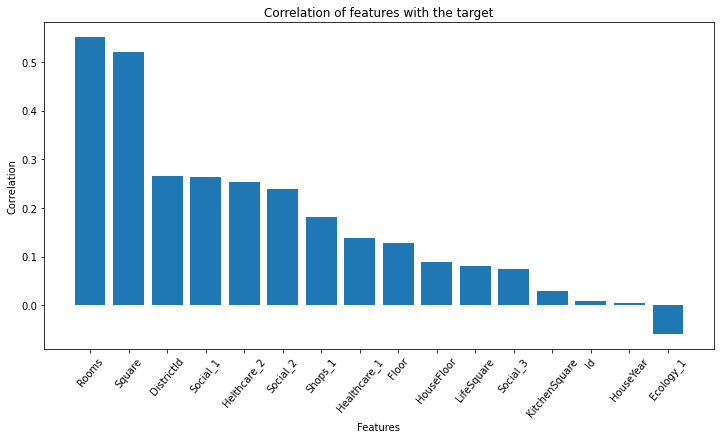

In [763]:
correlation = train_df.corrwith(train_df['Price']).sort_values(ascending=False)
correlation.drop('Price', inplace=True)

plt.figure(figsize=(12, 6))
plt.bar(correlation.index, correlation)
plt.xticks(rotation=50)
plt.xlabel('Features')
plt.ylabel('Correlation')
plt.title('Correlation of features with the target')

plt.show()

In [764]:
train_df.describe()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
count,10000.00000,10000.000000,10000.000000,10000.000000,7887.000000,10000.000000,10000.000000,10000.0000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,5202.000000,10000.000000,10000.000000,10000.000000
mean,8383.40770,50.400800,1.890500,56.315720,37.199665,6.273300,8.526700,12.6094,3.990166e+03,0.118858,24.687000,5352.157400,8.039200,1142.904419,1.319500,4.231300,214138.937500
std,4859.01902,43.587592,0.839522,21.058716,86.241219,28.560839,5.241148,6.7762,2.005003e+05,0.119025,17.532614,4006.799803,23.831875,1021.519470,1.493601,4.806341,92872.273438
min,0.00000,0.000000,0.000000,1.136859,0.370619,0.000000,1.000000,0.0000,1.910000e+03,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,59174.777344
25%,4169.50000,20.000000,1.000000,41.774879,22.769833,1.000000,4.000000,9.0000,1.974000e+03,0.017647,6.000000,1564.000000,0.000000,350.000000,0.000000,1.000000,153872.628906
50%,8394.50000,36.000000,2.000000,52.513309,32.781261,6.000000,7.000000,13.0000,1.977000e+03,0.075424,25.000000,5285.000000,2.000000,900.000000,1.000000,3.000000,192269.648438
75%,12592.50000,75.000000,2.000000,65.900627,45.128803,9.000000,12.000000,17.0000,2.001000e+03,0.195781,36.000000,7227.000000,5.000000,1548.000000,2.000000,6.000000,249135.460938
max,16798.00000,209.000000,19.000000,641.065186,7480.592285,2014.000000,42.000000,117.0000,2.005201e+07,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,633233.437500


### 2. Processing of emissions + NaN

#### ~ class DataPreprocessing

In [786]:
class DataPreprocessing:
    
    def __init__(self):
        self.cLife = None
        self.cKitn = None
        self.cSquare = None
        self.medians = None
        self.binary_to_numbers = None
        self.condSquare = None
    
    def fit(self, X):
        # medians
        self.medians = X.median()
        
        
    def transform(self, X):
        """data transformation"""
        
        # < Rooms >
        X['_RoomsBug'] = 0
        X.loc[(train_df['Rooms'] == 0) | (X['Rooms'] >= 6), '_RoomsBug'] = 1

        X.loc[train_df['Rooms'] == 0, 'Rooms'] = 1
        X.loc[train_df['Rooms'] >= 6, 'Rooms'] = 5
        
        
        # < Square, LifeSquare, KitchenSquare >
        
        # CONDITIONS
 
        ## LifeSquare: NaN | > 200 | < 6
        self.cLife = (X['LifeSquare'].isna()) | (X['LifeSquare'] < 6) | (X['LifeSquare'] > 200)

        ## KitchenSquare: NaN | > 40 | < 3
        self.cKitn = X['KitchenSquare'].isna() | (X['KitchenSquare'] < 2) | (X['KitchenSquare'] > 40)
    
        condition = ~self.cLife & ~self.cKitn
        ## Square: NaN | > 300 | < 12 | < (LifeSquare + KitchenSquare + 3)
        self.cSquare = (X['Square'] > 300) | (X['Square'] < 10) | X['Square'].isna() | (X.loc[condition, 'Square'] < (X.loc[condition, 'LifeSquare'] + X.loc[condition, 'KitchenSquare'] + 3))

        
        # Marks
        ## _SquareBug
        X['_SquareBug'] = 0
        X.loc[self.cSquare, '_SquareBug'] = 1

        ## _LifeSquareBug
        X['_LifeSquareBug'] = 0
        X.loc[self.cLife, '_LifeSquareBug'] = 1

        ## _KitchenSquareBug
        X['_KitchenSquareBug'] = 0
        X.loc[self.cKitn, '_KitchenSquareBug'] = 1

        
        # MEDIAN RATIOS by DistrictId
        df = X[~self.cLife & ~self.cKitn & ~self.cSquare]

        # Ratios: life/square & kitchen/square by DistrictIdf
        df = df.groupby(['DistrictId', 'Rooms'])['LifeSquare', 'KitchenSquare', 'Square'].median()
        df['_K_Life'] = df['LifeSquare'] / df['Square']
        df['_K_Kitn'] = df['KitchenSquare'] / df['Square']
        
        # Add K (features) by DistrictId + count Rooms
        X = X.merge(df[['_K_Life', '_K_Kitn']], how='left', on=['DistrictId', 'Rooms'])
        
        # DistrictId + count Rooms K not Found --> K = K.median()
        X.loc[X['_K_Life'].isna(), '_K_Life'] = X['_K_Life'].median()
        X.loc[X['_K_Kitn'].isna(), '_K_Kitn'] = X['_K_Kitn'].median()
        
        
        ## < Square >
         ## LifeSquare: NaN | > 200 | < 6
        self.cLife = (X['LifeSquare'].isna()) | (X['LifeSquare'] < 6) | (X['LifeSquare'] > 200)

        ## KitchenSquare: NaN | > 40 | < 3
        self.cKitn = X['KitchenSquare'].isna() | (X['KitchenSquare'] < 3) | (X['KitchenSquare'] > 40)
    
        condition = ~self.cLife & ~self.cKitn
        
        ## Square: NaN | > 300 | < 12 | < (LifeSquare + KitchenSquare + 3)
        self.cSquare = (X['Square'] > 300) | (X['Square'] < 12) | X['Square'].isna() | (X.loc[condition, 'Square'] < (X.loc[condition, 'LifeSquare'] + X.loc[condition, 'KitchenSquare'] + 3))
        
        
        # > 300 --> Square / 10
        X.loc[X['Square'] > 300, 'Square'] = X.loc[X['Square'] > 300, 'Square'] / 10
        # < 8 --> Square * 10
        X.loc[X['Square'] < 8, 'Square'] = X.loc[X['Square'] < 8, 'Square'] * 10
        # NaN --> Square.median()
        X.loc[X['Square'].isna(), 'Square'] = X['Square'].median()
        
        
        # < KitchenSquare >
        X.loc[X['KitchenSquare'] > 40, 'KitchenSquare'] = X.loc[X['KitchenSquare'] > 40, 'KitchenSquare'] / 10
        
        X.loc[self.cKitn, 'KitchenSquare'] = X.loc[self.cKitn, 'Square'] * X.loc[self.cKitn, '_K_Kitn']
        X.loc[X['Square'] < X['LifeSquare'] + X['KitchenSquare']]
        
        
        # < LifeSquare >
        ## LS = S * K_LS
        X.loc[self.cLife, 'LifeSquare'] = X.loc[cLife, 'Square'] * X.loc[self.cLife, '_K_Life']

        ## S < LS + KS --> LS = S * LSk - 4
        self.condSquare = X['Square'] < X['LifeSquare'] + X['KitchenSquare']
        X.loc[self.condSquare, 'LifeSquare'] = X.loc[self.condSquare, 'Square'] * X.loc[self.condSquare, '_K_Life'] - 4

        
        # HouseFloor, Floor
        X.loc[X['HouseFloor'] == 0, 'HouseFloor'] = X[train_df['HouseFloor'] == 0]['Floor']
        X.loc[X['Floor'] > X['HouseFloor'], 'Floor'] = X[X['Floor'] > X['HouseFloor']]['HouseFloor']
        
        
        #HouseYear
        X.loc[(X['HouseYear'] < 1900), 'HouseYear'] = int(X['HouseYear'].median())
        X.loc[(X['HouseYear'] > 2020), 'HouseYear'] = 2020

        
        # Healthcare_1
        X.loc[X['Healthcare_1'].isna(), 'Healthcare_1'] = X['Healthcare_1'].median()
        
        
        # Helthcare_2
        X.rename(columns={'Helthcare_2': 'Healthcare_2'}, inplace=True)
        X.fillna(self.medians, inplace=True)
        
        
        # DistrictId == NaN --> median DistrictId and main features

        def DistrictIdMedian(feature='DistrictId'):
            condDistrictId = train_df['DistrictId'].isna()

            if feature == 'DistrictId':
                X.loc[condDistrictId, feature] = 111111
            else:
                X.loc[condDistrictId, feature] = train_df[feature].median()


        for val in ['Square', 'LifeSquare', 'KitchenSquare', 'Rooms', 'DistrictId']:
            DistrictIdMedian(val)
        
        
        ## Create ratio lifeSquare / square (for replace NaN LifeSquare) (by DistrictId)
        district_lsq_mean = X.groupby('DistrictId').mean()['LifeSquare']
        district_sq_mean = X.groupby('DistrictId').mean()['Square']
    
        k_mean_life_square = pd.DataFrame(district_lsq_mean / district_sq_mean, columns=['K_LS_S']).reset_index()
    
        X = X.merge(k_mean_life_square, on=['DistrictId'], how='left')
        
        return X

### 4. Building new features 

In [787]:
class FeatureGenerator:
    """Generation of new features"""
    
    def __init__(self):
        self.DistrictId_counts = None
        self.binary_to_numbers = None
        self.med_price_by_district = None
        self.med_price_by_floor_year = None
        self.floor_min = None
        self.floor_max = None
        self.house_year_min = None
        self.house_year_max = None
        self.district_size = None
        self.mean_square_rooms = None
        
    
    def fit(self, X, y=None):
        
        X = X.copy()
        
        # Binary features
        self.binary_to_numbers = {'A': 1, 'B': 2}

        # DistrictId
        self.district_size = X['DistrictId'].value_counts()\
        .reset_index().rename(columns={'index': 'DistrictId', 'DistrictId': 'DistrictSize'})
        
        # Target encoding
        ## District, Rooms
        df = X.copy()
        
        if y is not None:
            df['Price'] = y.values
            
            self.med_price_by_district = df.groupby(['DistrictId', 'Rooms'], as_index=False).agg({'Price': 'median'})\
            .rename(columns={'Price': 'MedPriceByDistrict'})
            
            self.med_price_by_district_median = self.med_price_by_district['MedPriceByDistrict'].median()
            
        ## Floor, HouseYear
        if y is not None:
            self.floor_min = df['Floor'].min()
            self.floor_max = df['Floor'].max()
            self.house_year_min = df['HouseYear'].min()
            self.house_year_max = df['HouseYear'].max()
            df['Price'] = y.values
            df = self.floor_to_cat(df)
            df = self.year_to_cat(df)
            
            self.med_price_by_floor_year = df.groupby(['year_cat', 'floor_cat'], as_index=False).agg({'Price': 'median'})\
            .rename(columns={'Price': 'MedPriceByFloorYear'})
            
            self.med_price_by_floor_year_median = self.med_price_by_floor_year['MedPriceByFloorYear'].median()
            
            
    def transform(self, X):
        
        # Binary features
        X['Ecology_2'] = X['Ecology_2'].map(self.binary_to_numbers) # A -> 0, B -> 1
        X['Ecology_3'] = X['Ecology_3'].map(self.binary_to_numbers)
        X['Shops_2'] = X['Shops_2'].map(self.binary_to_numbers)
        
        # DistrictId, IsDistrictLarge
        X = X.merge(self.district_size, on=['DistrictId'], how='left')
        
        X['new_district'] = 0
        X.loc[X['DistrictSize'].isna(), 'new_district'] = 1
        
        X['DistrictSize'].fillna(5, inplace=True)
        
        X['IsDistrictLarge'] = (X['DistrictSize'] > 100).astype(int)
        
        # MeanLifeSquareRooms
        self.mean_square_rooms = X.groupby(['DistrictId'], as_index=False)[['Rooms', 'LifeSquare']].sum()
        
        self.mean_square_rooms['MeanLifeSquareRooms'] = \
        (self.mean_square_rooms['LifeSquare'] / self.mean_square_rooms['Rooms']).round().astype(int)
        self.mean_square_rooms.drop(columns=['Rooms', 'LifeSquare'], inplace=True)
        X = X.merge(self.mean_square_rooms, on=['DistrictId'], how='left')
        
        # MeanSquareRooms
        self.mean_square_rooms = X.groupby(['DistrictId'], as_index=False)[['Rooms', 'Square']].sum()
        
        self.mean_square_rooms['MeanSquareRooms'] = \
        (self.mean_square_rooms['Square'] / self.mean_square_rooms['Rooms']).round().astype(int)
        self.mean_square_rooms.drop(columns=['Rooms', 'Square'], inplace=True)
        X = X.merge(self.mean_square_rooms, on=['DistrictId'], how='left')
        
        # More Categorical features
        X = self.floor_to_cat(X)
        X = self.year_to_cat(X)
        
        #target encoding
        if self.med_price_by_district is not None:
            X = X.merge(self.med_price_by_district, on=['DistrictId', 'Rooms'], how='left')
            X['MedPriceByDistrict'].fillna(self.med_price_by_district_median, inplace=True)
        
        if self.med_price_by_floor_year is not None:
            X = X.merge(self.med_price_by_floor_year, on=['year_cat', 'floor_cat'], how='left')
            X['MedPriceByFloorYear'].fillna(self.med_price_by_floor_year_median, inplace=True)
            
        return X
    
    
    def floor_to_cat(self, X):
        bins = [self.floor_min, 3, 5, 9, 15, self.floor_max]
        X['floor_cat'] = pd.cut(X['Floor'], include_lowest=True, bins=bins, labels=False)
        X['floor_cat'].fillna(-1, inplace=True)
        
        return X
    
    
    def year_to_cat(self, X):
        bins= [self.house_year_min, 1941, 1945, 1980, 2000, 2010, self.house_year_max]
        X['year_cat'] = pd.cut(X['HouseYear'], bins=bins, labels=False)
        X['year_cat'].fillna(-1, inplace=True)
        
        return X
    
    

### 5. Feature selection

In [788]:
feature_names = [
    'Social_2',
    'Social_1',
    'Social_3',
    'Healthcare_2',
    'Square',
    'LifeSquare',
    'KitchenSquare',
    'Floor',
    'HouseYear',
    'Ecology_2'
]

#, 'Rooms', 'Healthcare_2','Social_1', 'Social_2', 'Social_3', 'Shops_2', 'Shops_1', 'Ecology_1', 'Ecology_2', 'Ecology_3'
#'Rooms',

new_feature_names = [
    'MedPriceByDistrict',
    'MedPriceByFloorYear',
    'MeanLifeSquareRooms',
    #'MeanSquareRooms',
    'DistrictSize',
    'IsDistrictLarge',
    #'K_LS_S'
]

#'Rooms_outlier', 'MedPriceByFloorYear', 'DistrictSize', 'IsDistrictLarge', 'Rooms_outlier',  'MedPriceByDistrict', 

target_name = 'Price'

### 6. Splitting into train / test

In [789]:
train_df = pd.read_csv(TRAIN_DATASET_PATH)
test_df = pd.read_csv(TEST_DATASET_PATH)

X = train_df.drop(columns=target_name)
y = train_df[target_name]

In [790]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=.2, shuffle=True, random_state=21)

In [791]:
preprocessor = DataPreprocessing()
preprocessor.fit(X_train)

X_train = preprocessor.transform(X_train)
X_valid = preprocessor.transform(X_valid)
test_df = preprocessor.transform(test_df)

X_train.shape, X_valid.shape, test_df.shape

((8000, 26), (2000, 26), (5000, 26))

In [792]:
features_gen = FeatureGenerator()
features_gen.fit(X_train, y_train)

X_train = features_gen.transform(X_train)
X_valid = features_gen.transform(X_valid)
test_df = features_gen.transform(test_df)

In [793]:
X_train.shape, X_valid.shape, test_df.shape

((8000, 35), (2000, 35), (5000, 35))

In [794]:
X_train = X_train[feature_names + new_feature_names]
X_valid = X_valid[feature_names + new_feature_names]
test_df = test_df[feature_names + new_feature_names]

In [795]:
X_train.isna().sum().sum(), X_valid.isna().sum().sum(), test_df.isna().sum().sum()

(0, 0, 0)

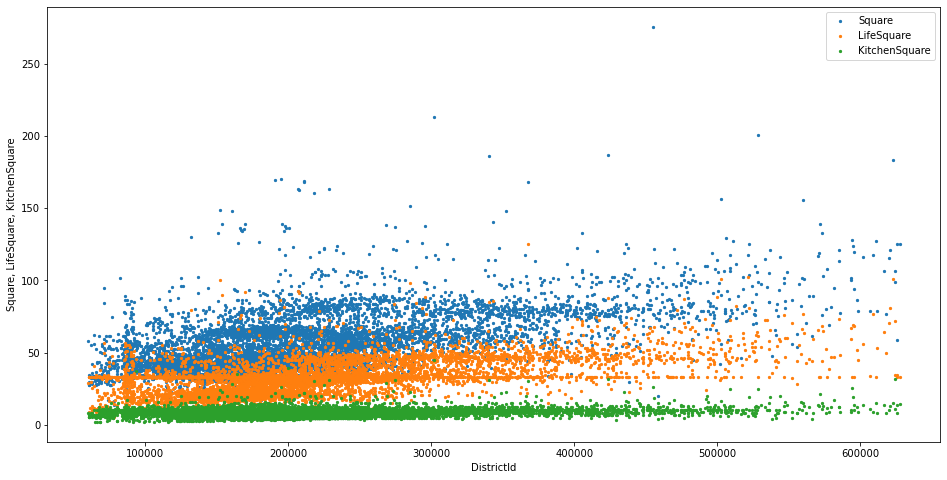

In [796]:
# Square, LifeSqure, KitchenSquare
TypeSquares = ['Square', 'LifeSquare', 'KitchenSquare']

plt.figure(figsize=(16, 8))

for feature in TypeSquares:
    plt.scatter(y_train, X_train[feature], label=feature, s=5)

plt.xlabel('DistrictId')
plt.ylabel('Square, LifeSquare, KitchenSquare')
plt.legend()
plt.show()

### 7. Building a model

In [797]:
# rf_model = RandomForestRegressor(random_state=21, criterion='mse')
# rf_model.fit(X_train, y_train)

In [798]:
# y_train_preds = rf_model.predict(X_train)
# y_test_preds = rf_model.predict(X_valid)

# evaluate_preds(y_train, y_train_preds, y_valid, y_test_preds)

In [799]:
#cv_score = cross_val_score(rf_model, X_train, y_train, scoring='r2', cv=KFold(n_splits=3, shuffle=True, random_state=21))
#cv_score

In [800]:
#cv_score.mean()

In [801]:
#feature_importances = pd.DataFrame(zip(X_train.columns, rf_model.feature_importances_), columns=['feature_name', 'importance'])
#feature_importances.sort_values(by='importance', ascending=False)

In [802]:
from sklearn.tree import DecisionTreeRegressor, plot_tree

Train R2:	0.941
Test R2:	0.716


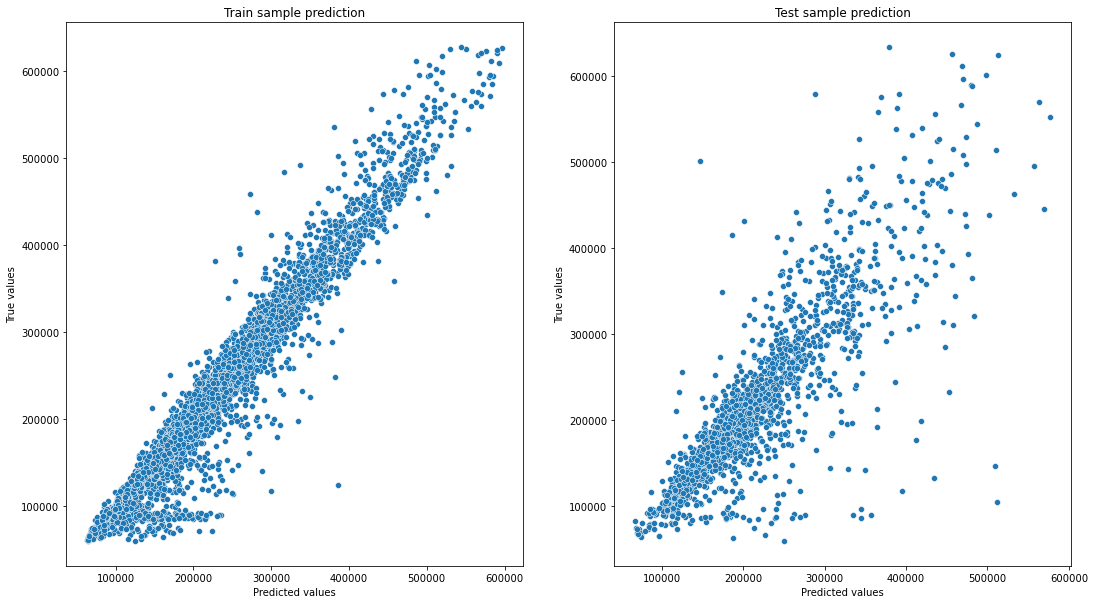

In [803]:
rf_model = RandomForestRegressor(
    criterion='mse',
    max_depth=20,  # глубина дерева
    min_samples_leaf=2,  # минимальное количество наблюдений в листе дерева
    random_state=42,
    n_estimators=550  # количество деревьев
)

rf_model.fit(X_train, y_train)

y_train_preds = rf_model.predict(X_train)
y_test_preds = rf_model.predict(X_valid)
evaluate_preds(y_train, y_train_preds, y_valid, y_test_preds)
#0.941, 0.728

Train R2:	0.909
Test R2:	0.735


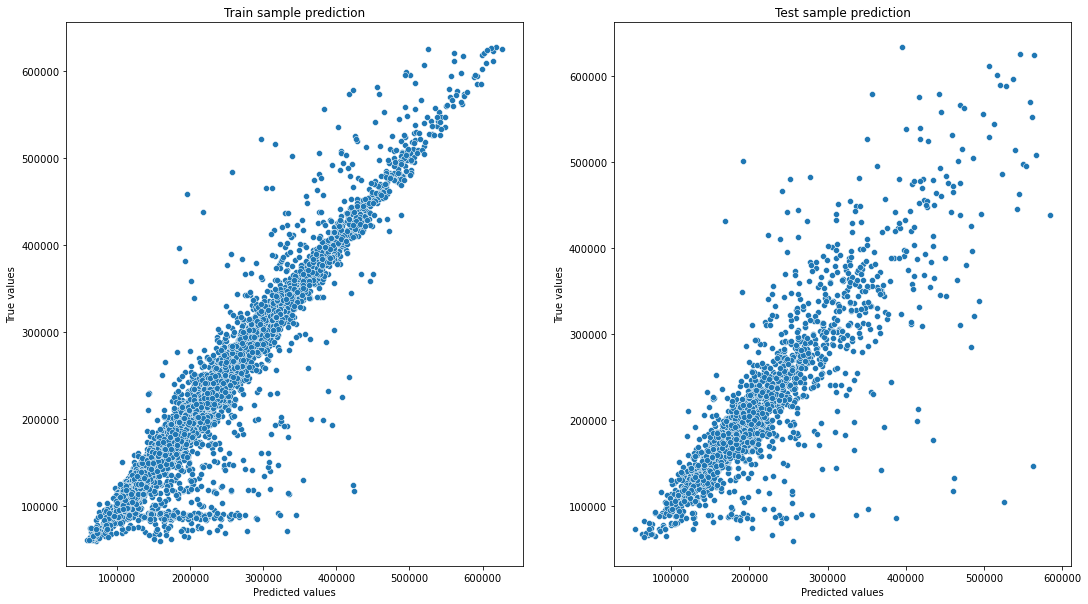

In [831]:
gb_model = GradientBoostingRegressor(criterion='mse',
                                     max_depth=6,
                                     min_samples_leaf=50,
                                     random_state=42,  
                                     n_estimators=1500, 
                                     max_features='sqrt', 
                                     loss='huber', 
                                     learning_rate=0.126)

gb_model.fit(X_train, y_train)

y_train_preds = gb_model.predict(X_train)
y_test_preds = gb_model.predict(X_valid)
evaluate_preds(y_train, y_train_preds, y_valid, y_test_preds)

In [805]:
# gb_model = GradientBoostingRegressor(
#     criterion='mse',
#     max_depth=5,
#     min_samples_leaf=7,
#     random_state=42,
#     n_estimators=350
# )

# gb_model.fit(X_train, y_train)

# y_train_preds = gb_model.predict(X_train)
# y_test_preds = gb_model.predict(X_valid)
# evaluate_preds(y_train, y_train_preds, y_valid, y_test_preds)
# #0.88 0.727

### 8. Prediction on test dataset

In [806]:
test_df.shape

(5000, 15)

In [807]:
submit = pd.read_csv('./input/real_estate_price_prediction_moscow/sample_submission.csv')

In [808]:
predictions = rf_model.predict(test_df)
predictions

array([156380.17326462, 127578.26442313, 138377.85320327, ...,
       148805.62441002, 180862.51403994, 283031.83743485])

In [809]:
submit['Price'] = predictions
submit.head()

,Id,Price
0,4567,156380.173265
1,5925,127578.264423
2,960,138377.853203
3,3848,143552.105833
4,746,174392.116940


In [833]:
submit.to_csv('./input/real_estate_price_prediction_moscow/rf_submit22.csv', index=False)